<a href="https://colab.research.google.com/github/Shatakd/Face-Emotion-Recognition-Deep-Learning/blob/main/Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Table of Contents**

- [Project Introduction](#1)
- [Importing Dependencies](#2)
- [Defining Prerequisites](#2)
- [Modified LeNet](#2)
- [AlexNet](#2)
- [MobileNetV2](#2)
- [VGG16](#2)
- [VGG19](#2)
- [Custom Model](#2)
- [Basic Inception](#2)
- [ResNet](#2)



<a name='1'></a>
# **Project Introduction**


The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms.

Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge.

In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (ex- Zoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts
which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.

## **Problem Statements**

We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.

**Face Emotion Recognition:**
This is a few shot learning live face emotion detection system. The model should be able to real-time identify the emotions of students in a live class.

<a name='2'></a>
# **Importing Dependencies**

In [4]:
# Importing libraries and dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19, ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os 
tf.random.set_seed(42)

In [5]:
# Importing the drive to save trained models
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Downloading the dataset
!gdown --id 1kdAI0wrR_bTBs-6pbKB6giz-JcNaTY-s

# Unzipping the files
!unzip '/content/dataset.zip'

In [7]:
# Defining te path of train and test dataset
train_dir = '/content/train'
test_dir = '/content/test'

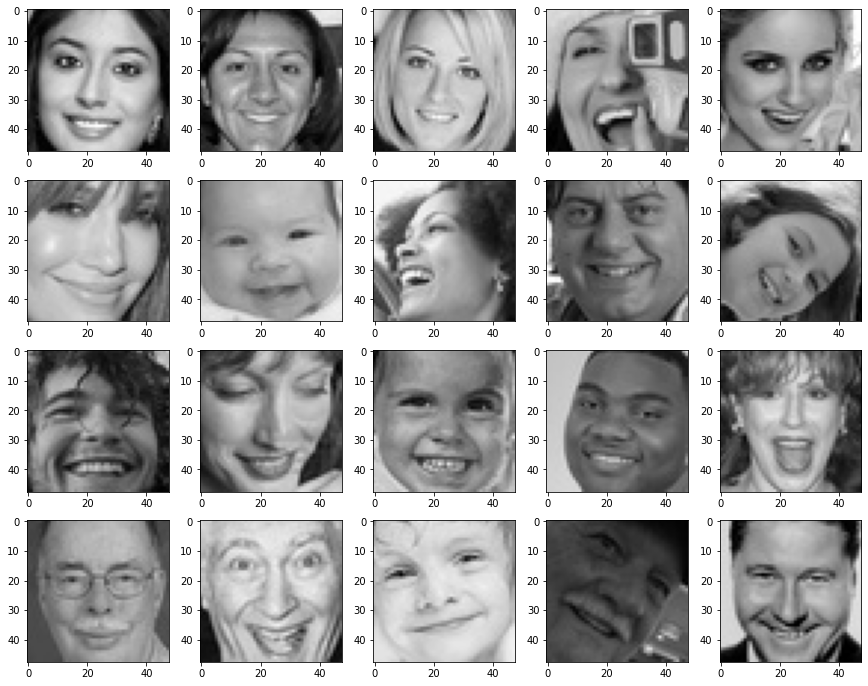

In [8]:
# Displaying sample Images
path = '/content/train/happy/'
plt.figure(figsize=(15,12))
for i in range(1, 21):
    plt.subplot(4,5,i)
    img = load_img(path + os.listdir(path)[i])
    plt.imshow(img)   
plt.show()

In [9]:
# Generating batches of tensor image data with real-time data augmentation.

batch = 64 # setting the batch size for mini batch
img = (48,48) # setting the dimensions for image
color = "grayscale" # setting the color mode for images

# Setting the Data Augumentation parameters for validation data set 
valid_gen = ImageDataGenerator(rescale=1./255)
# Setting the Data Augumentation parameters for training data set 
train_gen = ImageDataGenerator(rotation_range=20, rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True,
                              width_shift_range=0.1, height_shift_range=0.1)

# Fetching the files from train directory and performing the data augumentation
train_data = train_gen.flow_from_directory(train_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")
# Fetching the files from test directory and performing the data augumentation
validation = valid_gen.flow_from_directory(test_dir, target_size=img, batch_size=batch, color_mode=color, class_mode="categorical")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


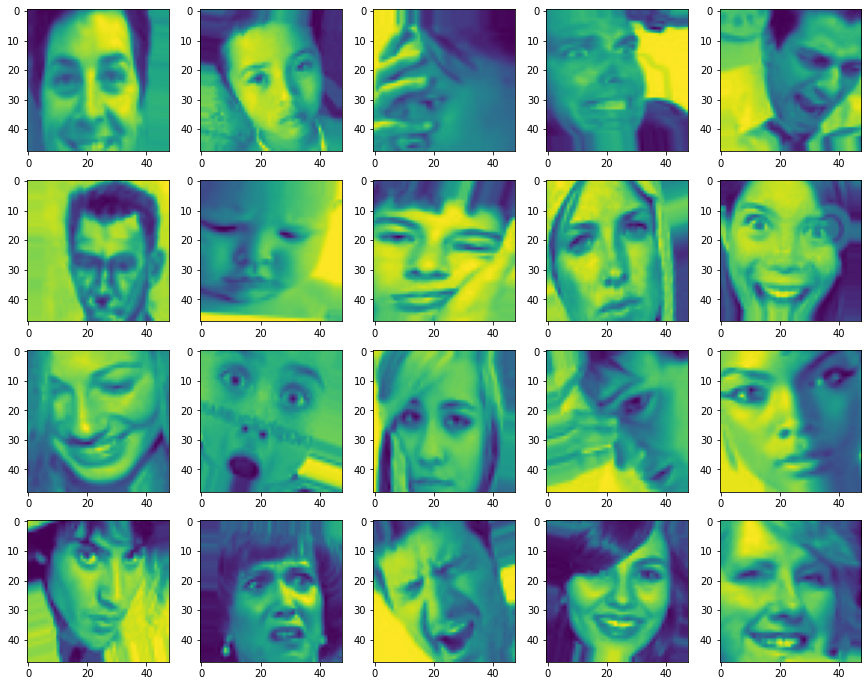

In [10]:
# Displaying sample images from the training set after augmentation
random_image = np.random.choice(64, size=20, replace=False)
random_batch = np.random.choice(112,size=20, replace=False)
fig,axes=plt.subplots(4,5,figsize=(15,12))
for id, ax in enumerate(axes.flatten()):
  pic = train_data[random_batch[id]][0][random_image[id]]
  ax.imshow(pic.reshape(48,-1))

In [11]:
# checking te shape of image and the label
image_batch, label_batch = next(iter(train_data))
print('image shape',image_batch[0].shape)
print('Label shape',label_batch[0].shape)

image shape (48, 48, 1)
Label shape (7,)


<a name='2'></a>
# **Defining prerequisites**

In [12]:
# Defining a function to generate callbacks
def callback_list(name, esp=9, lrp=3):
    ''' Defining a function to generate the list of callbacks
    Arguments:
        name -- name of the model
        esp -- early stopping patience
        lrp -- reduce learning rate patience
    Returns:
        the list of callbacks
    '''
    # Callback to save the Keras model or model weights at some frequency.
    checkpoint = ModelCheckpoint(f"/content/drive/MyDrive/{name}.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    # Stop training when a monitored metric has stopped improving.
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=esp, verbose=1, restore_best_weights=True)
    # Reduce learning rate when a metric has stopped improving.
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=lrp, verbose=1, min_delta=0.0001)
    # Defining a list of all the callbacks
    callbacks = [earlystop, checkpoint, reduce_lr]

    return callbacks

In [13]:
# Plot the training and validation accuracy and loss
def plots(history):
    ''' Defining a function to Plot the accuracy and loss
    Arguments:
        model.history
    Returns:
        plots of accuracy and loss for train and validation data
    '''
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

<a name='2'></a>
# **Modified LeNet**

In [ ]:
# Defining modeified Lenet architecture using keras sequential API
lenet = Sequential([# First CNN layer
                    Conv2D(filters=6, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # Second CNN layer
                    Conv2D(filters=16, kernel_size=3, activation='relu',  padding='same'),
                    BatchNormalization(), MaxPool2D(pool_size = 2),
                    # flattening and Adding 2 fully connected layers
                    Flatten(),
                    Dense(120, activation='relu'),
                    Dense(84, activation='relu'),
                    # using a prediction layer with seven neuron 
                    Dense(7, activation='softmax')])

# Compiling the model
lenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
lenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 6)         60        
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        880       
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 16)       64        
 hNormalization)                                                 
                                                        

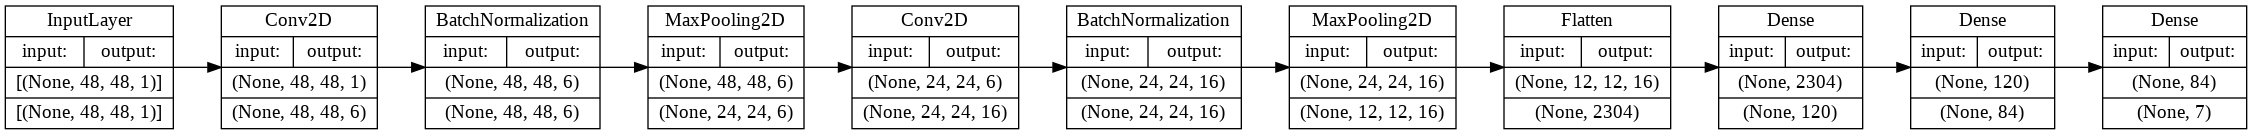

In [ ]:
# Plot model graph
plot_model(lenet, show_shapes=True, to_file='lenet.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
lenet_history = lenet.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('lenet'))

Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.8158 - accuracy: 0.2613
Epoch 1: val_loss improved from inf to 1.75408, saving model to /content/drive/MyDrive/lenet.h5
449/449 [==============================] - 33s 48ms/step - loss: 1.8156 - accuracy: 0.2616 - val_loss: 1.7541 - val_accuracy: 0.2926 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.7329 - accuracy: 0.3012
Epoch 2: val_loss improved from 1.75408 to 1.65202, saving model to /content/drive/MyDrive/lenet.h5
449/449 [==============================] - 21s 46ms/step - loss: 1.7329 - accuracy: 0.3012 - val_loss: 1.6520 - val_accuracy: 0.3568 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.6988 - accuracy: 0.3223
Epoch 3: val_loss did not improve from 1.65202
449/449 [==============================] - 20s 46ms/step - loss: 1.6988 - accuracy: 0.3223 - val_loss: 1.6749 - val_accuracy: 0.3491 - lr: 1.0000e-04
Epoch 4/100
449/

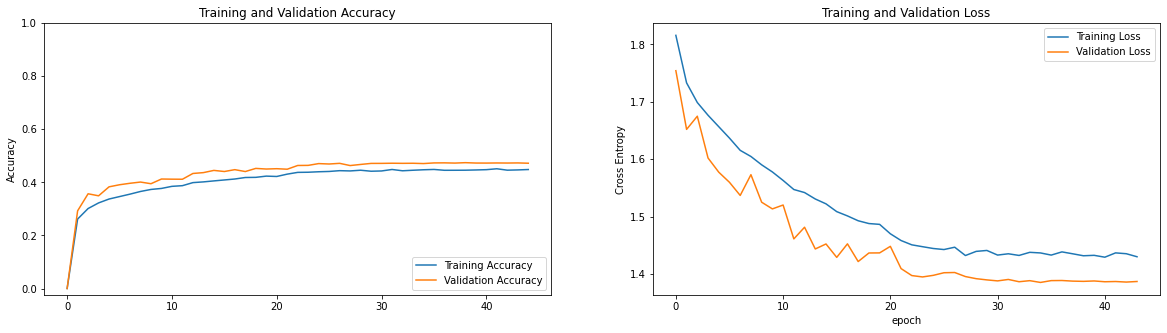

In [ ]:
# Plotting te accuracy and loss
plots(lenet_history)

<a name='2'></a>
# **Alexnet**

In [ ]:
# AlexNet CNN architecture from scratch using keras sequential API
alexnet = Sequential([# The first block with 1 conv
                      Conv2D(96, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The second block with 1 conv
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      BatchNormalization(), MaxPool2D(pool_size=(2,2)),
                      # The third block with 3 conv
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(384, kernel_size=3, activation='relu', padding='same'),
                      Conv2D(256, kernel_size=3, activation='relu', padding='same'),
                      MaxPool2D(pool_size=(2,2)),
                      # Flattening and Using 2 fully connected layer with 4096 units and relu activation
                      Flatten(),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      Dense(4096, activation='relu'), Dropout(0.5),
                      # Using a prediction layer with seven neuron
                      Dense(7, activation='softmax')])

# Compiling the model
alexnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 96)        960       
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 256)       221440    
                                                                 
 batch_normalization_3 (Batc  (None, 24, 24, 256)      1024      
 hNormalization)                                                 
                                                      

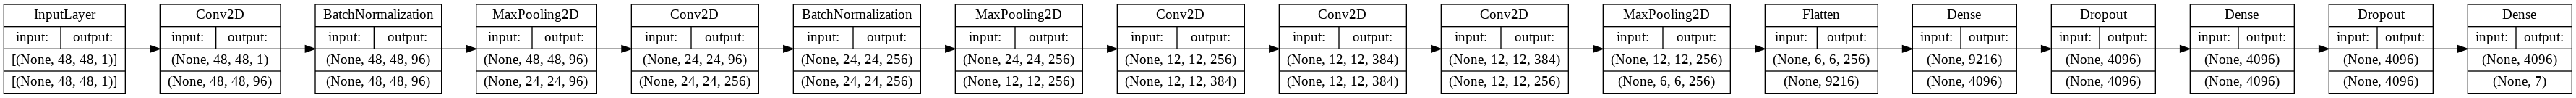

In [ ]:
# Plot model graph
plot_model(alexnet, to_file='alexnet.png', show_shapes=True, rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
alexnet_history = alexnet.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('alexnet'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.7493 - accuracy: 0.2871
Epoch 1: val_loss improved from inf to 1.70837, saving model to /content/drive/MyDrive/alexnet.h5
449/449 [==============================] - 34s 71ms/step - loss: 1.7493 - accuracy: 0.2871 - val_loss: 1.7084 - val_accuracy: 0.3339 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.5202 - accuracy: 0.4031
Epoch 2: val_loss improved from 1.70837 to 1.36724, saving model to /content/drive/MyDrive/alexnet.h5
449/449 [==============================] - 35s 79ms/step - loss: 1.5202 - accuracy: 0.4031 - val_loss: 1.3672 - val_accuracy: 0.4780 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.3742 - accuracy: 0.4743
Epoch 3: val_loss improved from 1.36724 to 1.23614, saving model to /content/drive/MyDrive/alexnet.h5
449/449 [==============================] - 34s 77ms/step - loss: 1.3742 - accuracy: 0.4743 - val_loss: 1.23

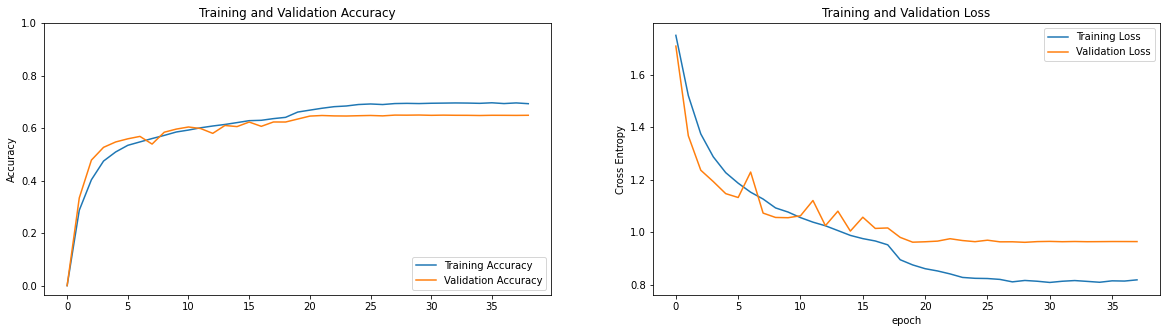

In [ ]:
# Plotting te accuracy and loss
plots(alexnet_history)

<a name='2'></a>
# **Mobilenet**

In [ ]:
# categorical classification using MobileNetV2 
mobilenet = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for mobilenet
                        Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                        # Using MobileNetV2
                        MobileNetV2(weights='imagenet', include_top=False, pooling = 'avg'),
                        # Using a fully connected layer with 128 units and relu activation
                        Dense(128, activation='relu'),
                        # Using a fully connected layer with 64 units and relu activation
                        Dense(64, activation='relu'),
                        # Using a prediction layer with seven neuron
                        Dense(7, activation='softmax')])

# Compiling the model
mobilenet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
mobilenet.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 3)         30        
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2,430,693
Trainable params: 2,396,581
Non-t

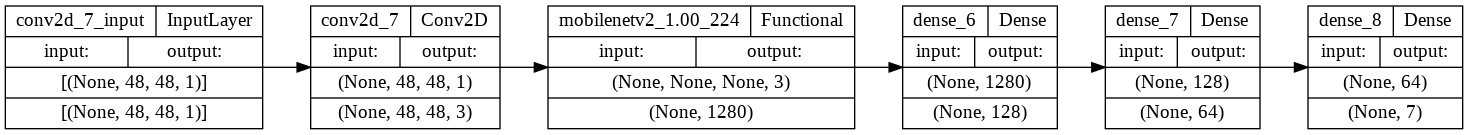

In [ ]:
# Plot model graph
plot_model(mobilenet, show_shapes=True, to_file='mobilenet.png', rankdir='LR')

In [ ]:
# Fitting the model
mobilenet_history = mobilenet.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('mobilenet'))

Epoch 1/100
448/449 [============================>.] - ETA: 0s - loss: 1.8735 - accuracy: 0.2479
Epoch 1: val_loss improved from inf to 1.91710, saving model to /content/drive/MyDrive/mobilenet.h5
449/449 [==============================] - 35s 67ms/step - loss: 1.8733 - accuracy: 0.2479 - val_loss: 1.9171 - val_accuracy: 0.2182 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.6994 - accuracy: 0.3208
Epoch 2: val_loss improved from 1.91710 to 1.86034, saving model to /content/drive/MyDrive/mobilenet.h5
449/449 [==============================] - 29s 64ms/step - loss: 1.6994 - accuracy: 0.3208 - val_loss: 1.8603 - val_accuracy: 0.2558 - lr: 1.0000e-04
Epoch 3/100
448/449 [============================>.] - ETA: 0s - loss: 1.6389 - accuracy: 0.3561
Epoch 3: val_loss improved from 1.86034 to 1.80237, saving model to /content/drive/MyDrive/mobilenet.h5
449/449 [==============================] - 29s 64ms/step - loss: 1.6386 - accuracy: 0.3563 - val_loss

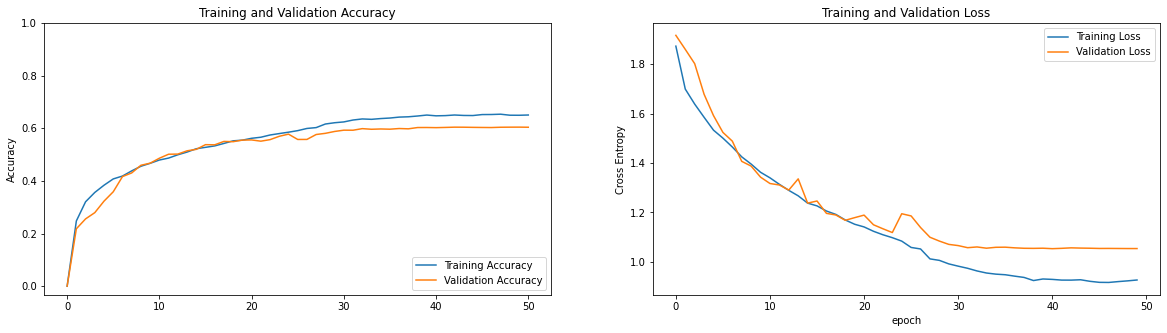

In [ ]:
# Plotting te accuracy and loss
plots(mobilenet_history)

<a name='2'></a>
# **VGG16**

In [ ]:
# Implementing VGG16 architecture
vgg16 = Sequential([# Adding a conv layer to get outputs with 3 channels to make it compatible for vgg16
                    Conv2D(3, kernel_size=3, padding='same', input_shape=(48, 48, 1)),
                    # Using VGG16 and Flattening the output
                    VGG16(include_top=False), Flatten(), BatchNormalization(),
                    # Using 2 fully connected layer with 4096 units and relu activation
                    Dense(4096, activation='relu'), BatchNormalization(),
                    Dense(4096, activation='relu'), BatchNormalization(),
                    # Using a prediction layer with seven neuron
                    Dense(7, activation='softmax')])

# Compiling the model
vgg16.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
vgg16.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 48, 48, 3)         30        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_6 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_15 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_21 (Dense)            (None, 4096)              2101248   
                                                                 
 batch_normalization_16 (Bat  (None, 4096)             

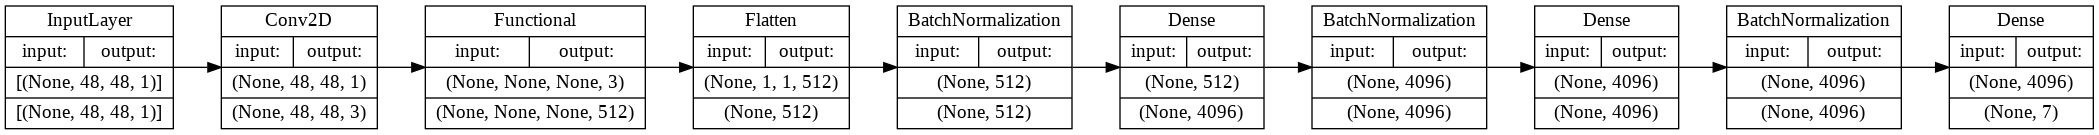

In [ ]:
# Plot model graph
plot_model(vgg16, show_shapes=True, to_file='vgg16.png', rankdir='LR', show_layer_names=False)

In [ ]:
# Fitting the model
vgg16_history = vgg16.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('vgg16'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8994 - accuracy: 0.3012
Epoch 1: val_loss improved from inf to 2.21909, saving model to /content/drive/MyDrive/vgg16.h5
449/449 [==============================] - 40s 82ms/step - loss: 1.8994 - accuracy: 0.3012 - val_loss: 2.2191 - val_accuracy: 0.3072 - lr: 1.0000e-04
Epoch 2/100
449/449 [==============================] - ETA: 0s - loss: 1.4957 - accuracy: 0.4310
Epoch 2: val_loss did not improve from 2.21909
449/449 [==============================] - 34s 75ms/step - loss: 1.4957 - accuracy: 0.4310 - val_loss: 3.7022 - val_accuracy: 0.1452 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.3884 - accuracy: 0.4757
Epoch 3: val_loss improved from 2.21909 to 1.46079, saving model to /content/drive/MyDrive/vgg16.h5
449/449 [==============================] - 37s 83ms/step - loss: 1.3884 - accuracy: 0.4757 - val_loss: 1.4608 - val_accuracy: 0.4546 - lr: 1.0000e-04
Epoch 4/100
449/

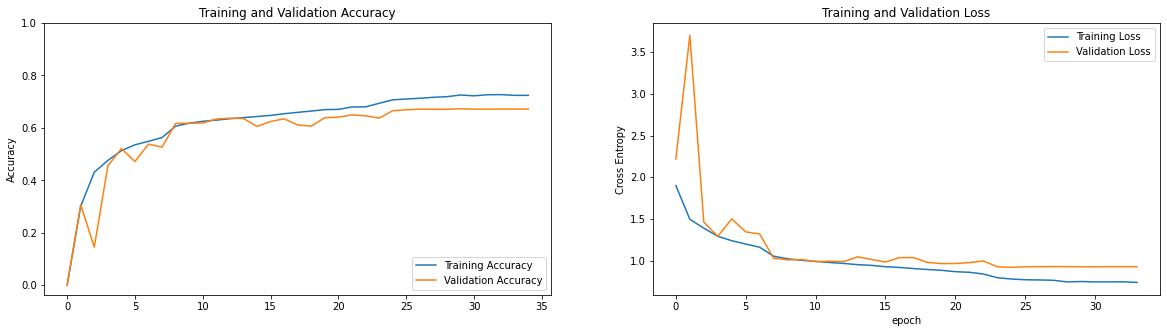

In [ ]:
# Plotting te accuracy and loss
plots(vgg16_history)

<a name='2'></a>
# **Custom Model**

In [14]:
# Defining a custom CNN architecture using keras sequential API
custom_model = Sequential([# First CNN layer
                           Conv2D(filters=32, kernel_size=5, activation='relu', input_shape=(48, 48, 1)),
                           # Second CNN layer
                           Conv2D(filters=64, kernel_size=5, activation='relu'),
                           MaxPool2D(pool_size = 2),
                           # Third CNN layer and flattening te outputs
                           Conv2D(filters=128, kernel_size=3, activation='relu'),
                           MaxPool2D(pool_size = 2), Flatten(),
                           # Adding 2 fully connected layers with dropout
                           Dense(1024, activation='relu'), Dropout(0.5),
                           Dense(512, activation='relu'), Dropout(0.5),
                           # using a prediction layer with seven neuron 
                           Dense(7, activation='softmax')])

# Compiling the model
custom_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001, decay=1e-6), metrics=['accuracy'])

# checking summary
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10368)             0

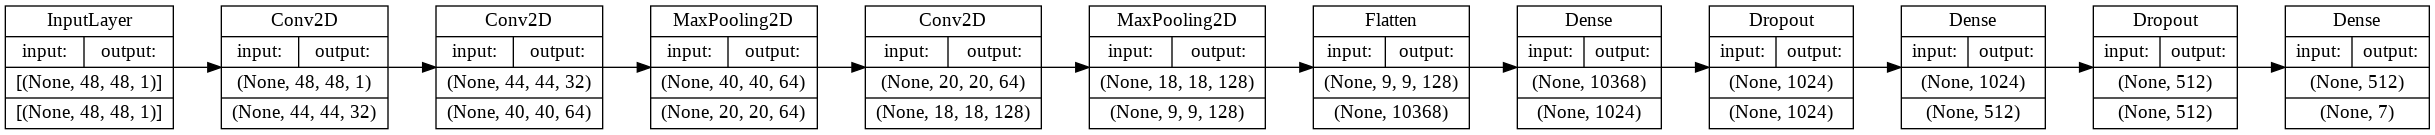

In [15]:
# Plot model graph
plot_model(custom_model, show_shapes=True, to_file='custom_model.png', rankdir='LR', show_layer_names=False)

In [16]:
# Fitting the model
custom_history = custom_model.fit(train_data, validation_data=validation, epochs=100, callbacks=callback_list('custom_model'))

Epoch 1/100
449/449 [==============================] - ETA: 0s - loss: 1.8071 - accuracy: 0.2525
Epoch 1: val_loss improved from inf to 1.72073, saving model to /content/drive/MyDrive/custom_model.h5
449/449 [==============================] - 38s 60ms/step - loss: 1.8071 - accuracy: 0.2525 - val_loss: 1.7207 - val_accuracy: 0.3246 - lr: 1.0000e-04
Epoch 2/100
448/449 [============================>.] - ETA: 0s - loss: 1.7342 - accuracy: 0.2962
Epoch 2: val_loss improved from 1.72073 to 1.60742, saving model to /content/drive/MyDrive/custom_model.h5
449/449 [==============================] - 29s 65ms/step - loss: 1.7341 - accuracy: 0.2963 - val_loss: 1.6074 - val_accuracy: 0.3692 - lr: 1.0000e-04
Epoch 3/100
449/449 [==============================] - ETA: 0s - loss: 1.6771 - accuracy: 0.3300
Epoch 3: val_loss improved from 1.60742 to 1.53573, saving model to /content/drive/MyDrive/custom_model.h5
449/449 [==============================] - 28s 63ms/step - loss: 1.6771 - accuracy: 0.3300 -

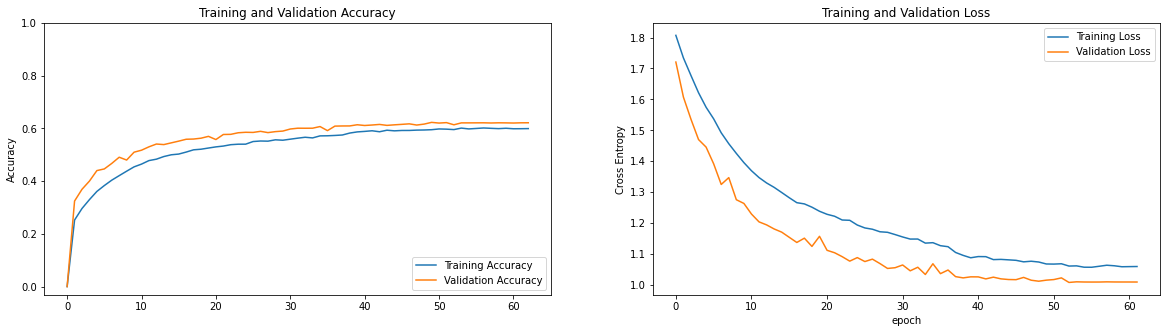

In [17]:
plots(custom_history)